## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

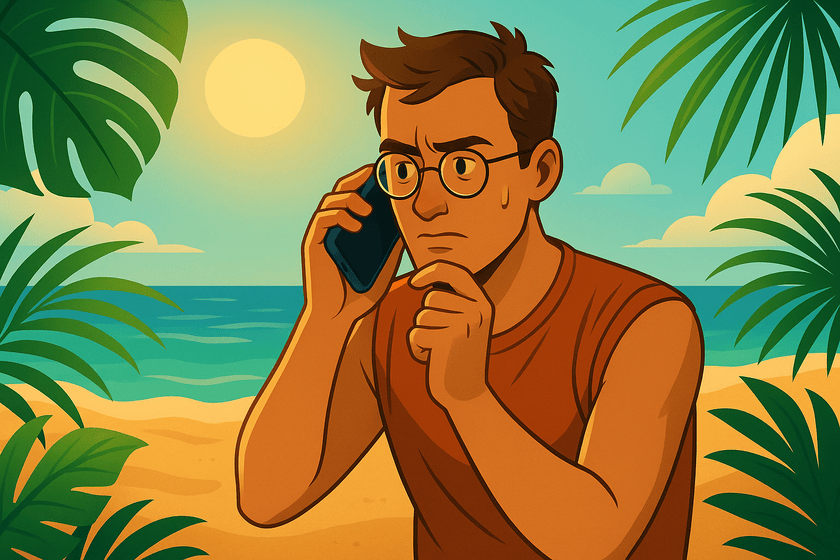

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

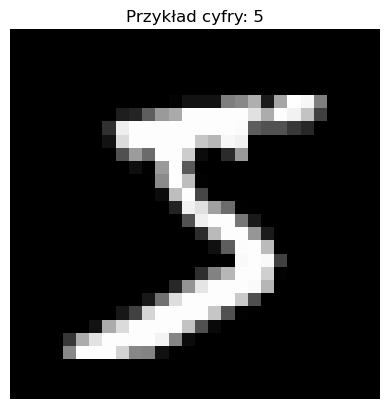

In [242]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

### Przydatne obserwacje z zadania 1:
Zapoznanie się z danymi i poznanie ważnych cech np. fakt, że obrazki są rozmiaru 28x28, jak wyglądają i jaki jest rozkład. 

Kluczową kwestią jest dobry podział danych.

Wizualizacje są super, nie tylko przy ocenie raportu, ale i przy tworzeniu go.

Przygotowanie danych

In [243]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
torch.manual_seed(SEED)

#transformacja
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

#pobranie danych
data_root = "./data"
train_full = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_ds    = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

#podzial danych
val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)

(55000, 5000, 10000)

Baseline - używam MLP, bo jest dosyć prosty i może być dobrym porównaniem przy lepszym modelu

In [244]:
import torch.nn as nn
import torch.nn.functional as F

class Baseline(nn.Module):
    def __init__(self, input_size=28*28, hidden_size1=256, hidden_size2=128, output_size=10):
        super(Baseline, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

model = Baseline().to(device)

Trening

In [245]:
def run_epoch(model, loader, criterion, optimizer=None, train=False):
    device = next(model.parameters()).device
    model.train() if train else model.eval()

    total_loss, correct, total = 0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        total_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return total_loss / total, correct / total

In [246]:
from torch.optim import Adam

def train_model(model, train_loader, val_loader, epochs=5, lr=1e-3):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs+1):
        tr_loss, tr_acc = run_epoch(model, train_loader, criterion, optimizer, train=True)
        val_loss, val_acc = run_epoch(model, val_loader, criterion, train=False)
        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch}: Train acc {tr_acc:.4f}, Val acc {val_acc:.4f}")
    
    return history

Funkcja wykresów przebiegu uczenia

In [247]:
import matplotlib.pyplot as plt

def plot_history(history, title="Model"):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title, fontsize=14)

    # Loss
    axs[0].plot(history["train_loss"], label="Train Loss")
    axs[0].plot(history["val_loss"], label="Val Loss")
    axs[0].set_xlabel("Epoka")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    # Accuracy
    axs[1].plot(history["train_acc"], label="Train Acc")
    axs[1].plot(history["val_acc"], label="Val Acc")
    axs[1].set_xlabel("Epoka")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

c:\Users\jastr\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1: Train acc 0.9150, Val acc 0.9506
Epoch 2: Train acc 0.9658, Val acc 0.9664
Epoch 3: Train acc 0.9777, Val acc 0.9744
Epoch 4: Train acc 0.9825, Val acc 0.9672
Epoch 5: Train acc 0.9861, Val acc 0.9736


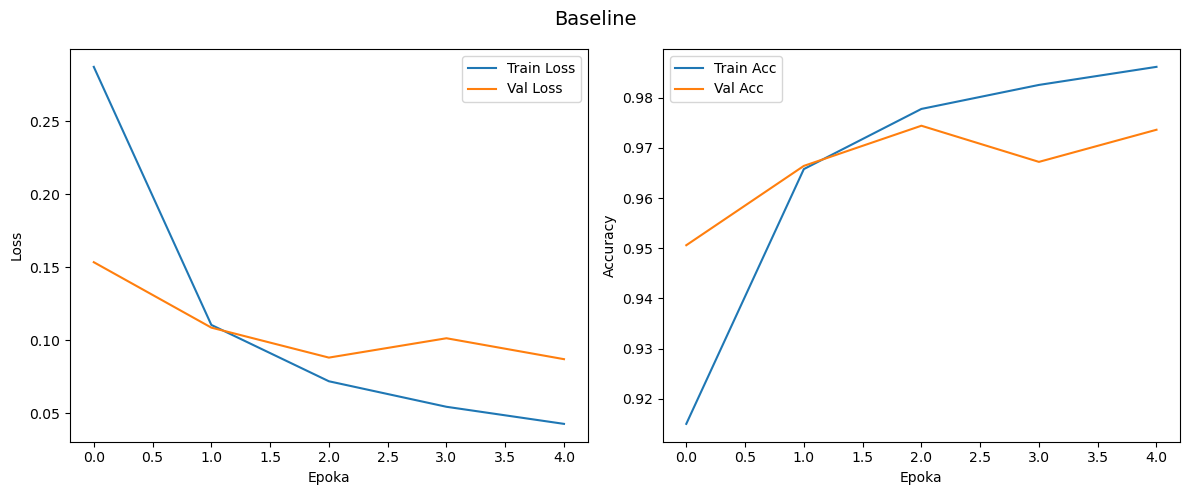

In [248]:
history = train_model(model, train_loader, val_loader, epochs=5, lr=1e-3)
torch.save(model.state_dict(), "baseline.pth")
plot_history(history, title="Baseline")

Ewaluacja

In [249]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch

def evaluate_and_plot(model, loader, device, title="Confusion Matrix"):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True)
            logits = model(xb)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(yb.numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)

    acc = (y_pred == y_true).mean()
    print(f"Test Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}", ha="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Prawdziwa klasa')
    plt.xlabel('Predykcja')
    plt.tight_layout()
    plt.show()
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

    return acc, y_true, y_pred


Test Accuracy: 0.9758


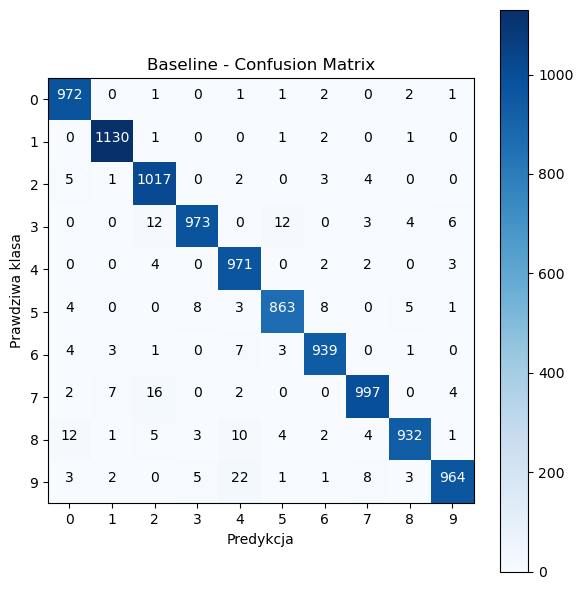

              precision    recall  f1-score   support

           0     0.9701    0.9918    0.9808       980
           1     0.9878    0.9956    0.9917      1135
           2     0.9622    0.9855    0.9737      1032
           3     0.9838    0.9634    0.9735      1010
           4     0.9538    0.9888    0.9710       982
           5     0.9751    0.9675    0.9713       892
           6     0.9791    0.9802    0.9797       958
           7     0.9794    0.9698    0.9746      1028
           8     0.9831    0.9569    0.9698       974
           9     0.9837    0.9554    0.9693      1009

    accuracy                         0.9758     10000
   macro avg     0.9758    0.9755    0.9755     10000
weighted avg     0.9760    0.9758    0.9758     10000



In [250]:
test_acc, y_true, y_pred = evaluate_and_plot(model, test_loader, device, title="Baseline - Confusion Matrix")

Jak na podstawowy model radzi sobie bardzo dobrze (Accuracy: 0.975). Najczęściej myli 9 z 4, 7 z 2 oraz 3 z 5.

Model CNN

In [251]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)

c:\Users\jastr\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1: Train acc 0.9385, Val acc 0.9782
Epoch 2: Train acc 0.9815, Val acc 0.9854
Epoch 3: Train acc 0.9871, Val acc 0.9834
Epoch 4: Train acc 0.9896, Val acc 0.9890
Epoch 5: Train acc 0.9924, Val acc 0.9888


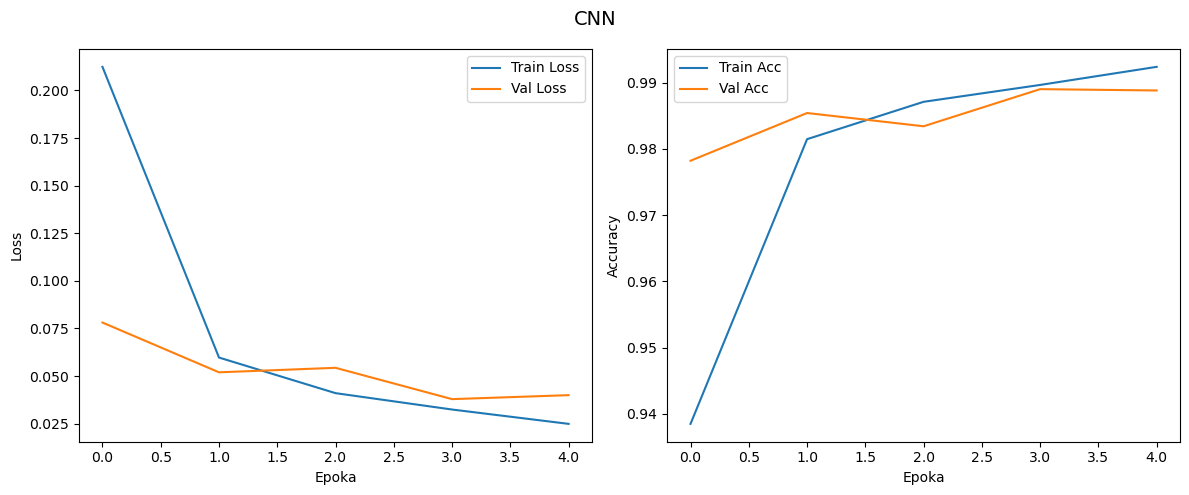

In [252]:
history = train_model(model, train_loader, val_loader, epochs=5, lr=1e-3)
torch.save(model.state_dict(), "cnn_model.pth")
plot_history(history, title="CNN")

Test Accuracy: 0.9883


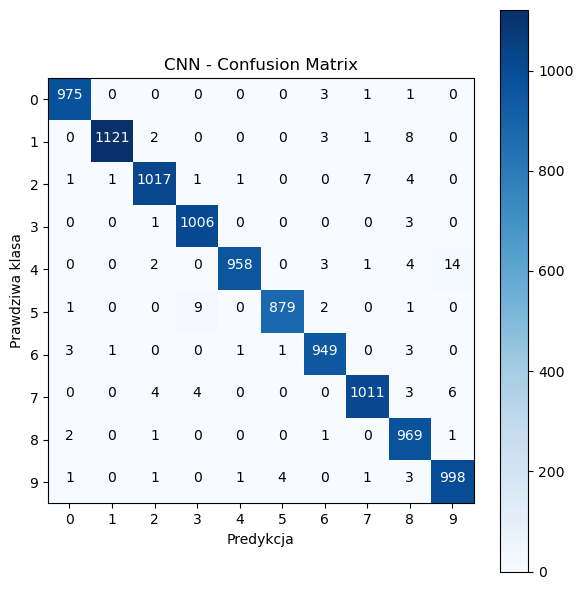

              precision    recall  f1-score   support

           0     0.9919    0.9949    0.9934       980
           1     0.9982    0.9877    0.9929      1135
           2     0.9893    0.9855    0.9874      1032
           3     0.9863    0.9960    0.9911      1010
           4     0.9969    0.9756    0.9861       982
           5     0.9943    0.9854    0.9899       892
           6     0.9875    0.9906    0.9891       958
           7     0.9892    0.9835    0.9863      1028
           8     0.9700    0.9949    0.9823       974
           9     0.9794    0.9891    0.9842      1009

    accuracy                         0.9883     10000
   macro avg     0.9883    0.9883    0.9883     10000
weighted avg     0.9884    0.9883    0.9883     10000



In [253]:

test_acc, y_true, y_pred = evaluate_and_plot(model, test_loader, device, title="CNN - Confusion Matrix")

Model CNN poradził sobie lepiej (Accuracy: 0.988) niż Baseline, ale dłużej się uczył. Najczęściej myli 4 z 9. 

Do CNN dodaje BatchNorm i Dropout

In [254]:
import torch.nn as nn
import torch.nn.functional as F

class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.dropout_conv = nn.Dropout2d(0.25)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


c:\Users\jastr\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1: Train acc 0.9588, Val acc 0.9848
Epoch 2: Train acc 0.9816, Val acc 0.9882
Epoch 3: Train acc 0.9845, Val acc 0.9886
Epoch 4: Train acc 0.9872, Val acc 0.9906
Epoch 5: Train acc 0.9897, Val acc 0.9904


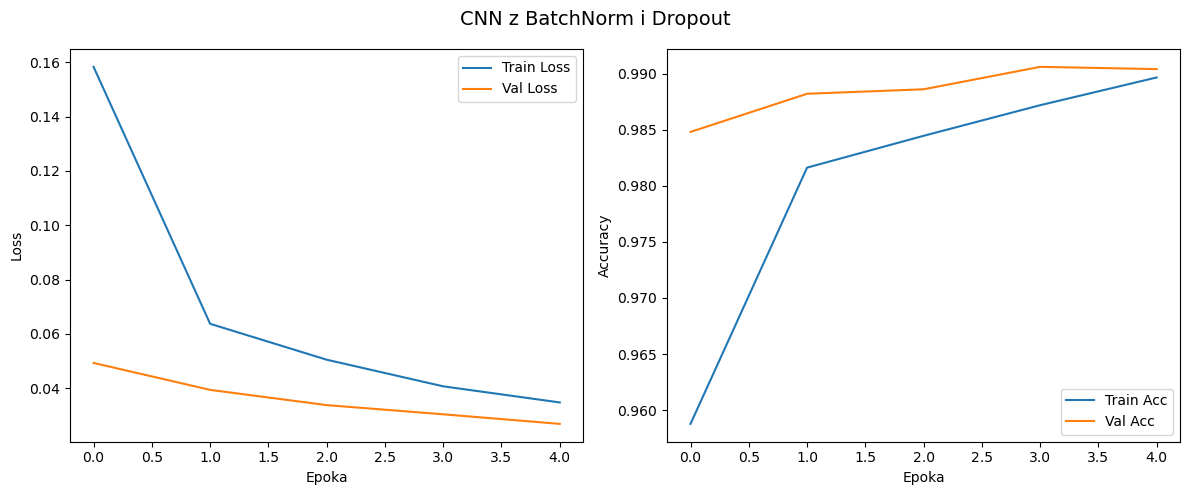

In [255]:
model_improved = CNN2().to(device)
history_improved = train_model(model_improved, train_loader, val_loader, epochs=5, lr=1e-3)
torch.save(model_improved.state_dict(), "cnn_dropout_bn.pth")
plot_history(history_improved, title="CNN z BatchNorm i Dropout")

Test Accuracy: 0.9883


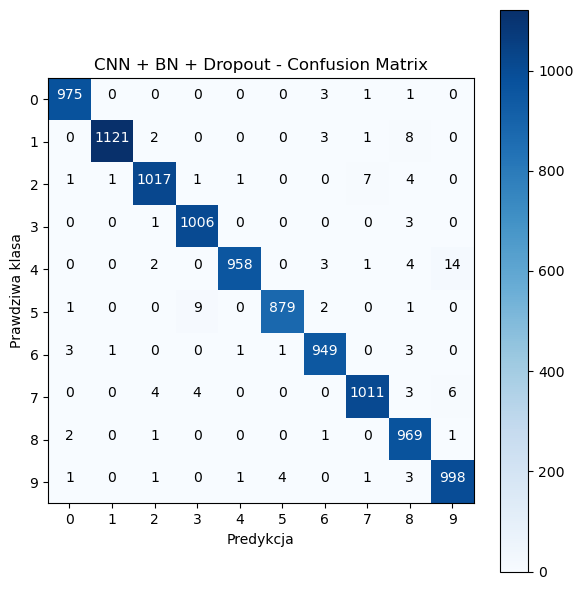

              precision    recall  f1-score   support

           0     0.9919    0.9949    0.9934       980
           1     0.9982    0.9877    0.9929      1135
           2     0.9893    0.9855    0.9874      1032
           3     0.9863    0.9960    0.9911      1010
           4     0.9969    0.9756    0.9861       982
           5     0.9943    0.9854    0.9899       892
           6     0.9875    0.9906    0.9891       958
           7     0.9892    0.9835    0.9863      1028
           8     0.9700    0.9949    0.9823       974
           9     0.9794    0.9891    0.9842      1009

    accuracy                         0.9883     10000
   macro avg     0.9883    0.9883    0.9883     10000
weighted avg     0.9884    0.9883    0.9883     10000



In [256]:
test_acc, y_true, y_pred = evaluate_and_plot(model, test_loader, device, title="CNN + BN + Dropout - Confusion Matrix")

'Ulepszony' CNN uczył się dłużej, niż podstawowa wersja, ale wynika to pewnie z większej złożoności. Osiągnięte wyniki są zbliżone do CNN (nie wiem czy wynika to z jakiegoś mojego błędu, czy tak ma być tbh). Podobnie do poprzednika najczęściej myli 4 z 9, ale ogólnie radzi sobie bardzo dobrze. 

c:\Users\jastr\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1: Train acc 0.9890, Val acc 0.9916
Epoch 2: Train acc 0.9898, Val acc 0.9906
Epoch 3: Train acc 0.9914, Val acc 0.9918
Epoch 4: Train acc 0.9925, Val acc 0.9922
Epoch 5: Train acc 0.9933, Val acc 0.9922
Epoch 6: Train acc 0.9939, Val acc 0.9932
Epoch 7: Train acc 0.9945, Val acc 0.9920
Epoch 8: Train acc 0.9949, Val acc 0.9932
Epoch 9: Train acc 0.9951, Val acc 0.9916
Epoch 10: Train acc 0.9955, Val acc 0.9932
Epoch 11: Train acc 0.9959, Val acc 0.9926
Epoch 12: Train acc 0.9953, Val acc 0.9932
Epoch 13: Train acc 0.9956, Val acc 0.9936
Epoch 14: Train acc 0.9960, Val acc 0.9936
Epoch 15: Train acc 0.9965, Val acc 0.9934
Epoch 16: Train acc 0.9967, Val acc 0.9940
Epoch 17: Train acc 0.9973, Val acc 0.9930
Epoch 18: Train acc 0.9968, Val acc 0.9940
Epoch 19: Train acc 0.9967, Val acc 0.9924
Epoch 20: Train acc 0.9972, Val acc 0.9938


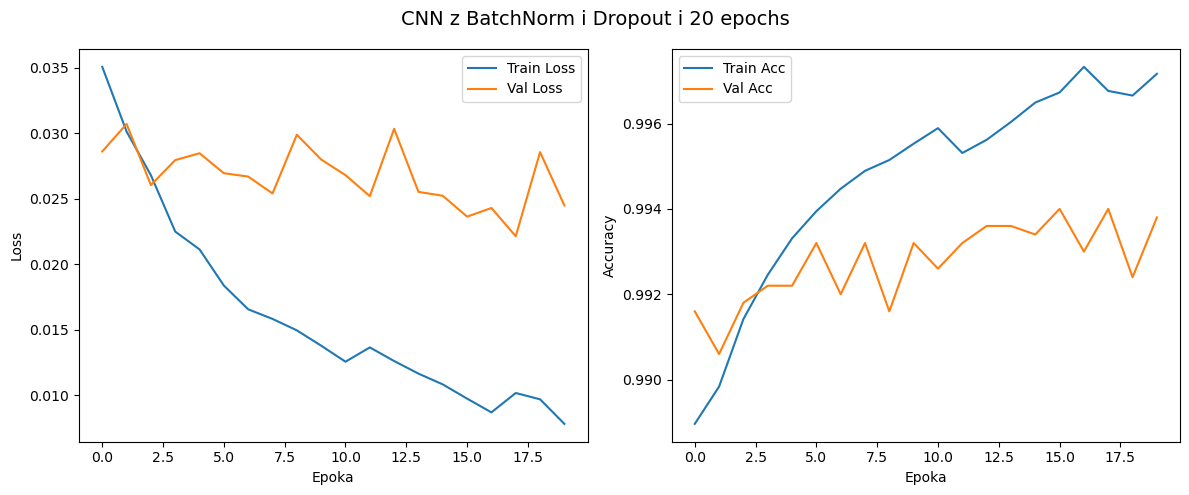

In [257]:
history_improved_2= train_model(model_improved, train_loader, val_loader, epochs=20, lr=1e-3)
torch.save(model_improved.state_dict(), "cnn_dropout_bn_20epochs.pth")
plot_history(history_improved_2, title="CNN z BatchNorm i Dropout i 20 epochs")

Test Accuracy: 0.9883


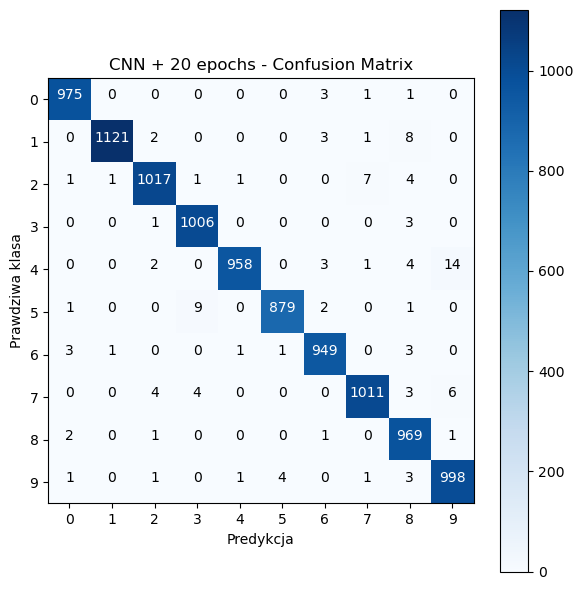

              precision    recall  f1-score   support

           0     0.9919    0.9949    0.9934       980
           1     0.9982    0.9877    0.9929      1135
           2     0.9893    0.9855    0.9874      1032
           3     0.9863    0.9960    0.9911      1010
           4     0.9969    0.9756    0.9861       982
           5     0.9943    0.9854    0.9899       892
           6     0.9875    0.9906    0.9891       958
           7     0.9892    0.9835    0.9863      1028
           8     0.9700    0.9949    0.9823       974
           9     0.9794    0.9891    0.9842      1009

    accuracy                         0.9883     10000
   macro avg     0.9883    0.9883    0.9883     10000
weighted avg     0.9884    0.9883    0.9883     10000



In [258]:
test_acc, y_true, y_pred = evaluate_and_plot(model, test_loader, device, title="CNN + 20 epochs - Confusion Matrix")

Wyniki są prawie identyczne co przy poprzedniku, więc albo mam błąd, albo nie warto używać bardziej zaawansowanego modelu na prostych danych - czas uczenia się znacznie wydłuży, a wyniki nie poprawią się. 

In [259]:
#Ładowanie:
#model.load_state_dict(torch.load("baseline", map_location=device))
#model.load_state_dict(torch.load("cnn_model", map_location=device))
#model.load_state_dict(torch.load("cnn_dropout_bn.pth", map_location=device))
#model.load_state_dict(torch.load("cnn_dropout_bn_20epochs.pth", map_location=device))


### Wnioski:
Wszystkie modele radzą sobie dobrze, ale największe trudności pojawiają się przy rozróżnianiu 4 i 9.

Czas treningu rośnie wraz ze złożonością modelu oraz liczbą epok.

Baseline ma trochę niższą dokładność niż modele CNN. Różnica jest niewielka (1-2 punkty procentowe), ale na bardziej złożonych zbiorach różnice mogą okazać się bardziej dotkliwe.

Dodanie Batch Normalization i Dropoutu do CNN poprawia stabilność uczenia, co widać po histogramach.

Macierz pomyłek jest super.

Przepraszam, jeśli całość jest nieczytelna lub chaotyczna, ale niestety nie miałam zbyt wiele czasu na wykonanie zadania. Temat jest dla mnie dość trudny i na pewno wymaga jeszcze dużo pracy oraz głębszego zrozumienia.